# Training an allosteric network at nonzero temperature

Begin with a few package imports:

In [1]:
from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt

from packing_utils import *
from allosteric_utils import *
from plot_imports import *
from lammps_utils import *

### Network generation

Create a small test network:

In [2]:
n = 48 # number of disks/nodes
seed = 0

net = Packing(n, rfac=0.8, seed=seed)
net.params['contact'] = 0.02 # reduce the default contact repulsion
net.generate()

progress: 100%|###########################################################################| 1000.00/1000.00 [00:02<00:00]


<IPython.core.display.Javascript object>


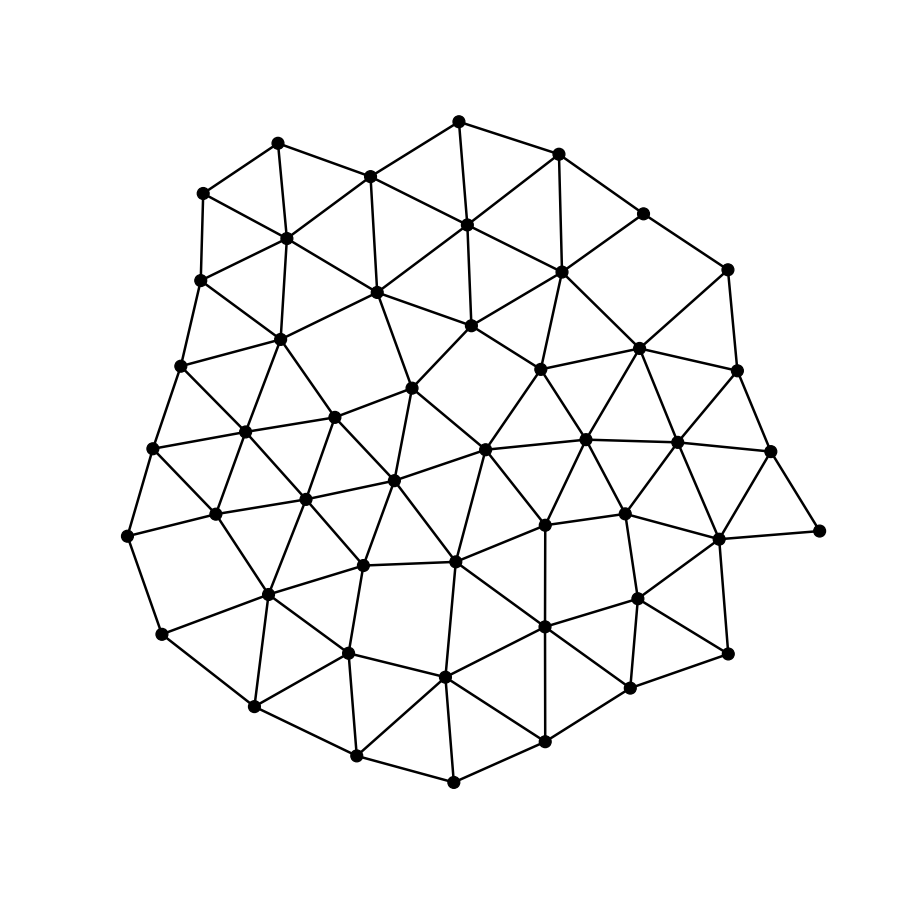

In [3]:
%matplotlib notebook

allo = Allosteric(net.graph, dim=2)
allo.plot()

Select a source and target at random:

<IPython.core.display.Javascript object>


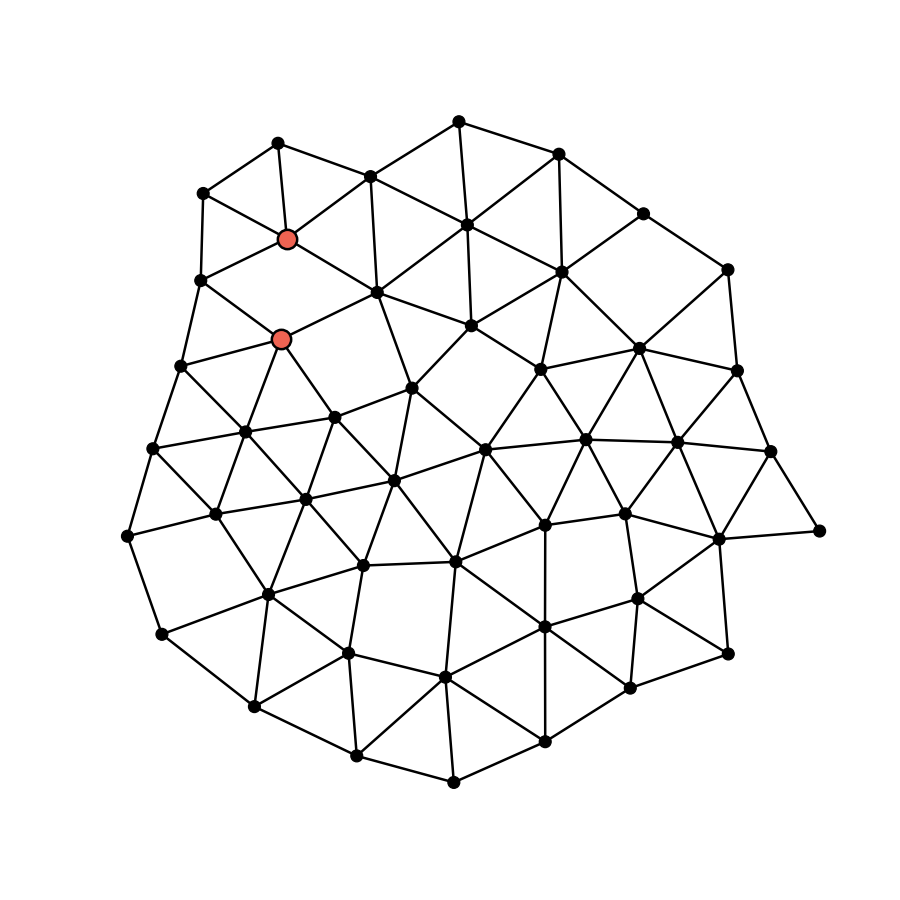

<IPython.core.display.Javascript object>


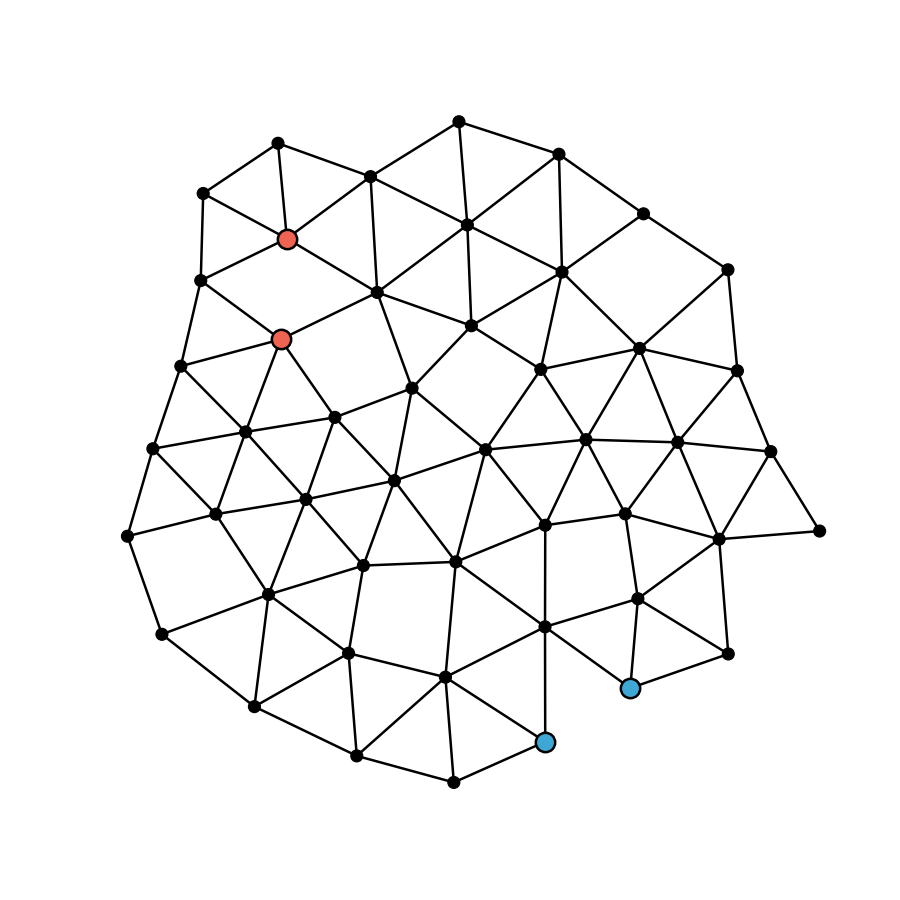

In [4]:
allo.add_targets(seed=seed)
allo.add_sources(seed=seed)

### Training

Specify a temperature, source and target strain to apply, training time, and training method. Also indicate the path to the LAMMPS executable you have installed.

In [5]:
temp = 1e-8

es = 0.2                # source strain of 20%
et = 0.2                # target strain of 20% applied to all targets
ka = 100.               # stiffness of spring for applied strain
duration = 1e6          # training time
frames = 400            # number of output frames
train = 2               # 1 trains bond rest lengths, 2 trains bond stiffnesses
method = 'learning'     # learning rule to use, 'aging' (directed aging) or 'learning' (coupled learning)

# compute the mean square bond length as a normalization factor
l2 = np.mean([edge[2]['length']**2 for edge in allo.graph.edges(data=True)])

eta = 1e-1              # nudge factor
alpha = 3e-3/l2         # learning rate
vmin = 1e-3             # minimum allowed stiffness

# path to LAMMPS executable - replace with your own!
lmp = '/path/to/lmp'

Since the network is untrained, applying a strain at the source (blue curve) produces no initial strain at the target:

progress: 100%|####################################################################9| 1000000.00/1000000.00 [00:03<00:00]


<IPython.core.display.Javascript object>


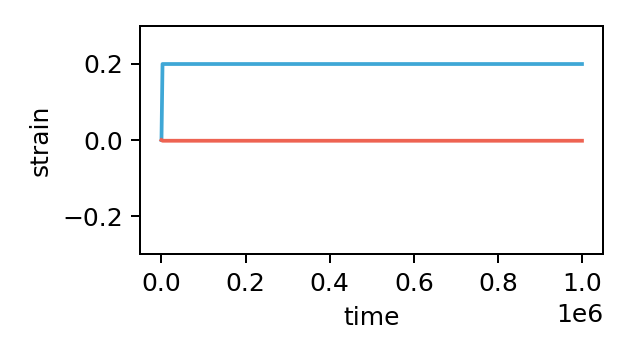

In [6]:
%matplotlib notebook

allo.reset_init()
sol = allo.solve(duration=duration, frames=frames, T=0, applied_args=(es, 0, ka))
allo.strain_plot()

The following function will set up a LAMMPS data and input file from the current network and place them in the specified output directory ```odir```. Here we name our output directory ```lammps```, which will be created automatically if it does not already exist.

In [7]:
odir = 'lammps/'          # output directory for LAMMPS files
prefix = 'temp_test'      # prefix used for naming the files

setup_run(allo, odir, prefix, lmp, duration, frames, (es, et, ka),
          train=train, method=method, eta=eta, alpha=alpha, vmin=vmin, temp=temp)

Simulation files written to: lammps/
Navigate to directory and run: /Users/jovanaandrejevic/git/learning/lammps/my_build/lmp -i temp_test.in -log temp_test.log
Or, navigate to directory and submit the job to the queue: sbatch job.sh


Once the LAMMPS simulation is finished, we can read out the results. In the plot below, the blue points show the source strain, and red points show the target strain.

<IPython.core.display.Javascript object>


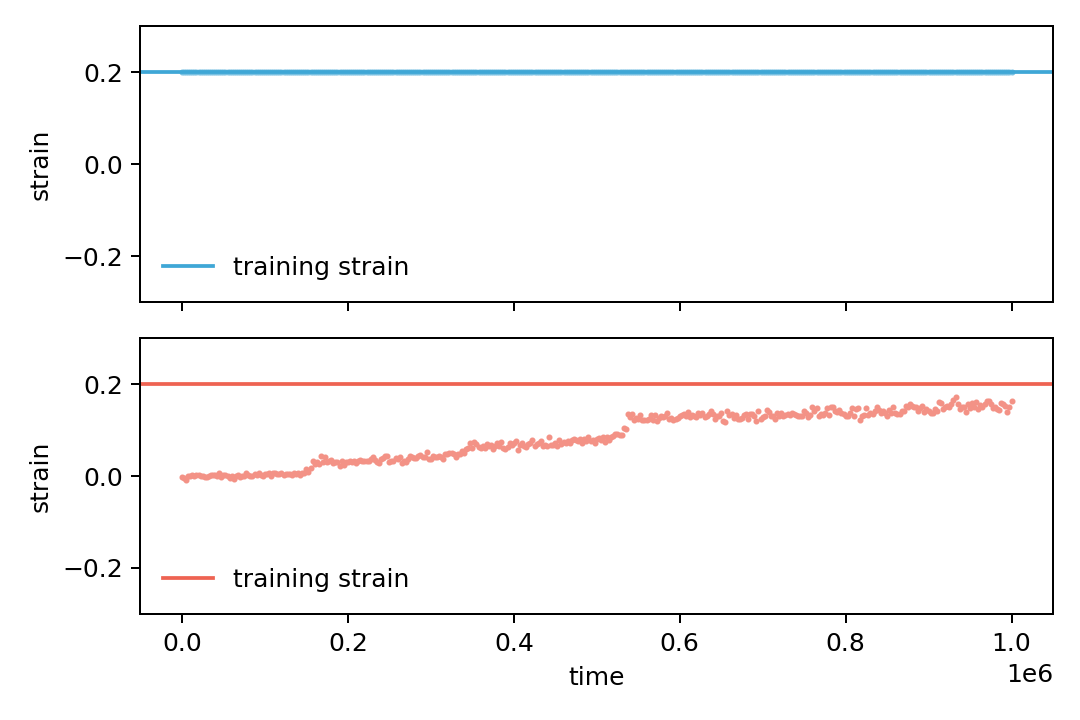

In [8]:
%matplotlib notebook

allo, data, cols = load_run(odir)
allo.strain_plot_thermal(es, et)

If the network is not fully trained, we can rerun `setup_run()` to re-create the simulation files, picking up where we left off. Note this will overwrite the previous files. Below we analyze the current network state.

### Visualization

View the final distribution of stiffnesses:

<IPython.core.display.Javascript object>


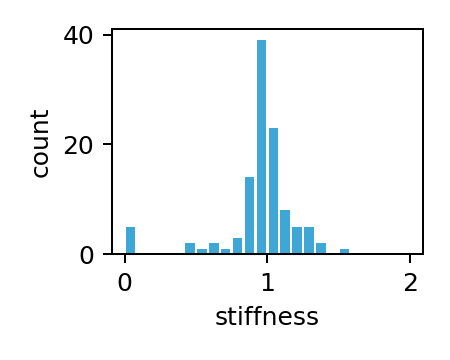

In [10]:
%matplotlib notebook

k = allo.distribution_plot(kind='stiffness', vmin=0, vmax=2, nbins=25)

Also visualize which bonds weakened (reds) and which bonds strengthened (blues):

<IPython.core.display.Javascript object>


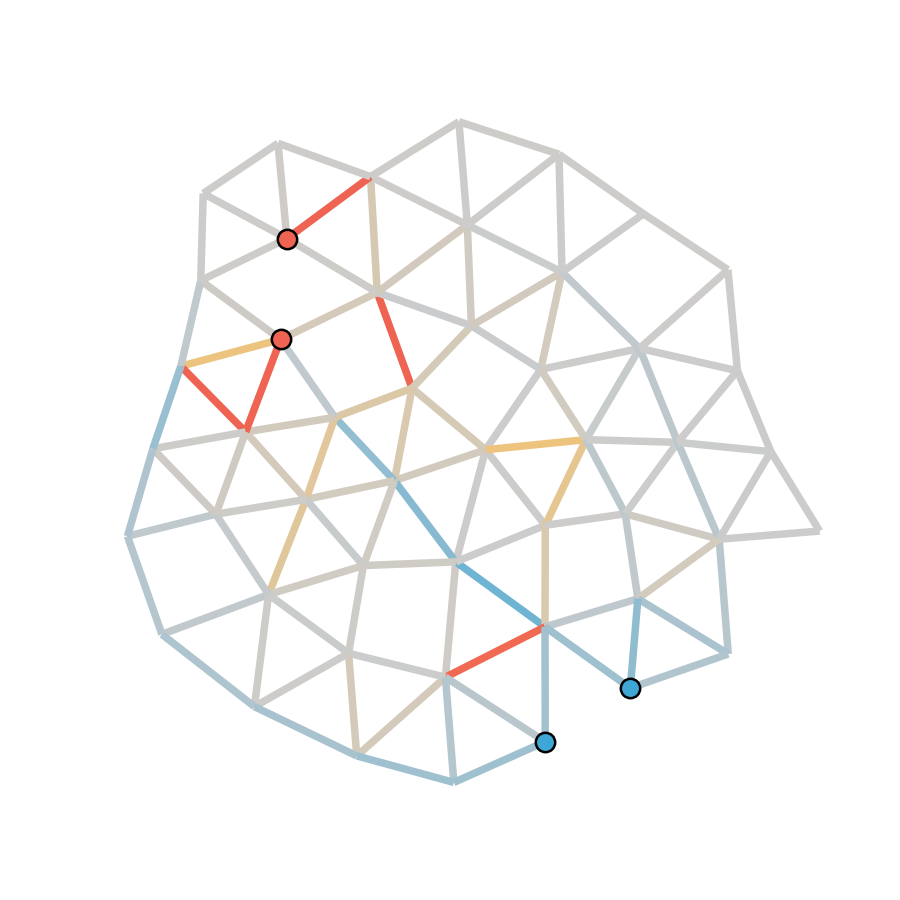

In [11]:
%matplotlib notebook

allo.reset_init() # reset network to its equilibrium state for visualization

cmap = continuous_cmap([pal['red'], pal['yellow'], np.array([0.8,0.8,0.8]),
                        pal['blue'], pal['purple']], [0,0.1,0.5,0.9,1])
allo.color_plot(cmap, vmin=0, vmax=2)

We can also check the corresponding zero temperature behavior the network has learned:

progress: 100%|####################################################################9| 1000000.00/1000000.00 [00:00<00:00]


<IPython.core.display.Javascript object>


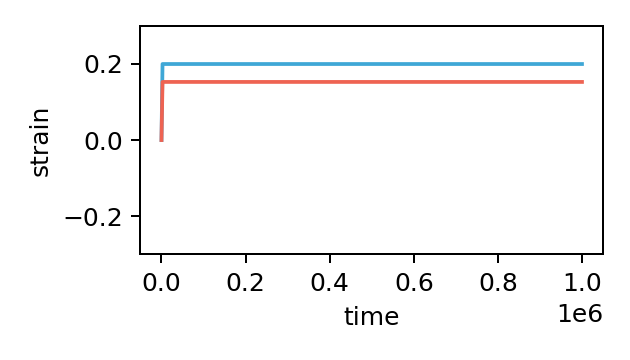

In [12]:
%matplotlib notebook

allo.reset_init()
sol = allo.solve(duration=duration, frames=frames, T=0, applied_args=(es, 0, ka))
allo.strain_plot()

Finally we can save the trained network:

In [13]:
allo.save('allo_thermal_{:d}.txt'.format(n))